# Assignment 3: Sensitivity Analysis with Sobol Indices
#### Moritz Kick, Maximilian Nowak

In [53]:
# Import modules from source
import os, sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin
from assignment2.lhs import latin_hypercube_uniform

# from sinfo import sinfo
# sinfo()

In [54]:
from assignment1.seir import seirc_model, G1, G2

beta = 14/9  # infection rate
alpha = 7/3  # incubation rate
gamma = 7/9  # recovery rate
i0 = 1000  # initial number of infected individuals

# Define initial conditions
N = 80e6
S0 = N - i0
E0 = 0
I0 = i0
R0 = 0
C0 = I0
y0 = [S0, E0, I0, R0, C0]

## Implementation of Sobol indices

### 1. Implement the construction of Sobol matrices

In [55]:
def create_sobol_matrices(A, B):
    n = A.shape[1]  # number of parameters
    N = A.shape[0]  # number of samples

    # Initialize Sobol matrices with shape (n, N, n)
    A_B = np.empty((n, N, n))

    # Generate Sobol matrices
    for i in range(n):
        A_B[i] = A.copy()  # start with a copy of A
        A_B[i, :, i] = B[:, i]  # replace the i-th column with B's i-th column

    return A_B


### 2. Implement the computation of Sobol total-effect indices

In [56]:
def compute_total_indices(f_A, f_A_B):
    # number of parameters
    n = f_A_B.shape[0]

    # Compute the variance
    var_f_A = np.var(f_A, ddof=1)

    # Compute total-effect indices
    S_T = np.empty(n)
    for i in range(n):
        S_T[i] = np.mean((f_A - f_A_B[i, :])**2) / (2.0 * var_f_A)
    return S_T


### 3. Verify your implementation

Create a simple mathematical function as your Quantity of Interest (QoI). Let's say the QoI is a quadratic function, $f(x, y, z, w) = x^2 + y^2 + z^2 + w^2$. This function has a known Sobol index for each parameter: each one contributes 25% of the total variance.

In [57]:
# Test function
def f(x):
    return np.sum(x**2, axis=1)

# Generate test inputs using LHS
np.random.seed(0)
n_samples = 10000
dim = 4
A = latin_hypercube_uniform(dim, n_samples)
B = latin_hypercube_uniform(dim, n_samples)

# Compute Sobol matrices
A_B = create_sobol_matrices(A, B)

# Compute test function values
f_A = f(A)
f_A_B = np.array([f(A_B[i]) for i in range(dim)])

# Compute Sobol total-effect indices
S_T = compute_total_indices(f_A, f_A_B)

print('Total-effect indices: ', S_T)


Total-effect indices:  [0.25127123 0.24490062 0.24399524 0.24998188]


## Application to the model

### 4. Construct sample matrices $A, B ∈ R^{N×n}$

In [58]:
np.random.seed(0)
n_samples = 10000
dim = 4
A = latin_hypercube_uniform(dim, n_samples)
B = latin_hypercube_uniform(dim, n_samples)

### 5. Compute vectors $G_l(A) ∈ R^N$ and $G_l(A^{(i)}) ∈ R^N$

In [59]:
# Define the time array outside of run_seirc
t = np.arange(0, 61, 1)  # for 60 weeks

def run_seirc(x):
    # Convert x to a tuple
    x = tuple(x)
    # Use the parameters from x to run the model
    seirc = seirc_model(x)
    output = seirc.solve(t, y0)
    return output

# Then leave the rest of your code as is:
outputs_A = np.array([run_seirc(A[i, :]) for i in range(n_samples)])
outputs_A_B = np.array([[run_seirc(A_B[j, i, :]) for i in range(n_samples)] for j in range(dim)])

G1_A = G1(outputs_A)
G1_A_B = np.array([G1(outputs_A_B[j]) for j in range(dim)])

G2_A = G2(outputs_A, t)
G2_A_B = np.array([G2(outputs_A_B[j], t) for j in range(dim)])


 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.1692664310648D+02   r2 =  0.9967769802085D-09
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.4319057797863D+02   r2 =  0.1226204143673D-07
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.5411806451016D+01   r2 =  0.6879994197492D-09
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.5322686418049D+02   r2 =  0.1167943266874D-07
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.3116228370310D+02   r2 =  0.3902625199579D-08
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin

### 6. Compute all Sobol total-effect indices $S_T$

In [60]:
S_T_G1 = compute_total_indices(G1_A, G1_A_B)
S_T_G2 = compute_total_indices(G2_A, G2_A_B)

print('Total-effect indices for G1: ', S_T_G1)
print('Total-effect indices for G2: ', S_T_G2)


Total-effect indices for G1:  [0.000677   0.02165939 0.01495827 0.00059316]
Total-effect indices for G2:  [0.00121953 0.02110196 0.00603184 0.00109152]


### 7.  Display the indices with a bar plot

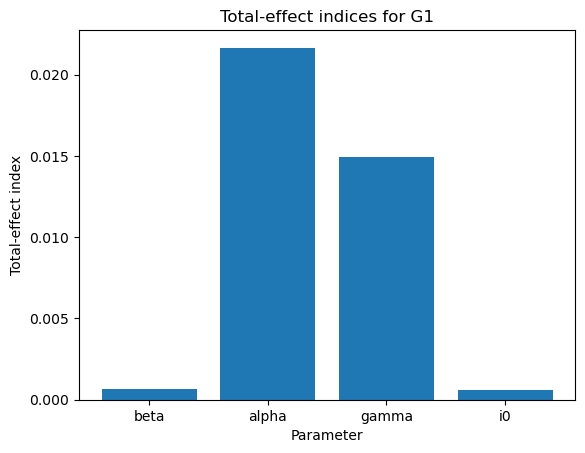

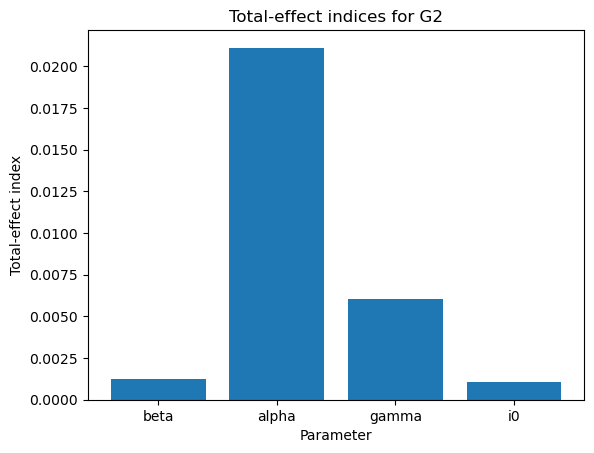

In [73]:
n = ['beta', 'alpha', 'gamma', 'i0']
plt.title('Total-effect indices for G1')
plt.bar(n, S_T_G1)
plt.xlabel('Parameter')
plt.ylabel('Total-effect index')
plt.show()

plt.title('Total-effect indices for G2')
plt.bar(n, S_T_G2)
plt.xlabel('Parameter')
plt.ylabel('Total-effect index')
plt.show()


### 8. Find a way to quantify the "amount of interaction between the variables"

To quantify the "amount of interaction between variables" in the context of a sensitivity analysis, you can look at "higher-order" sensitivity indices. The Sobol sensitivity indices we have calculated include both "first-order" indices, which represent the individual effect of each input variable on the output, and "total-order" indices, which represent the combined effect of each input variable and its interactions with all other variables.

The difference between the total-order and first-order indices for a given variable can give us a measure of the "amount of interaction" that variable has with the other variables. If the total and first order indices are close, it means that the variable mostly contributes alone to the output variance. If the total order index is much higher than the first order one, it means the variable often contributes through its interactions with other variables.

In [ ]:
# implementation of task 8

### 9. Compare the indices with the PRCCs from Assignment 2

For comparing the Sobol indices with the Partial Rank Correlation Coefficients (PRCCs) from Assignment 2, we need to keep in mind that they measure slightly different things:
- The PRCCs measure the strength and direction of the monotonic relationship between each input variable and the output, while holding all other variables constant. If a PRCC is close to 1 or -1, it suggests a strong positive or negative relationship, while a PRCC close to 0 suggests no relationship. PRCCs do not capture interactions between variables.

- The Sobol indices measure the proportion of the output variance that is due to each input variable, either alone (first-order) or in combination with others (total-order). If a Sobol index is close to 1, it suggests that the corresponding variable has a large effect on the output variance, while a Sobol index close to 0 suggests a small effect.


In [ ]:
# implementation of task 9